In [47]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import acquire_r
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk

In [2]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [79]:
# List of urls to scrape
g_url = ['https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=forks&type=Repositories', ' https://github.com/search?o=desc&p=2&q=stars%3A%3E1&s=forks&type=Repositories'\
         'https://github.com/search?o=desc&p=3&q=stars%3A%3E1&s=forks&type=Repositories', 'https://github.com/search?o=desc&p=4&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=5&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=6&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=7&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=8&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=9&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=10&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=11&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=12&q=stars%3A%3E1&s=forks&type=Repositories']

In [83]:
def get_repos(urls):
    repo = []
    for url in urls:
        time.sleep(10)
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
        text = soup.find_all(attrs={"f4 text-normal"})
        for i in text:
            repo.append(i.find('a')['href'])
    return repo


In [84]:
repos = get_repos(g_url)

In [91]:
repos

['/jtleek/datasharing',
 '/rdpeng/ProgrammingAssignment2',
 '/octocat/Spoon-Knife',
 '/tensorflow/tensorflow',
 '/SmartThingsCommunity/SmartThingsPublic',
 '/twbs/bootstrap',
 '/github/gitignore',
 '/rdpeng/ExData_Plotting1',
 '/tensorflow/models',
 '/nightscout/cgm-remote-monitor',
 '/facebook/react',
 '/DataScienceSpecialization/courses',
 '/angular/angular.js',
 '/jlord/patchwork',
 '/barryclark/jekyll-now',
 '/Snailclimb/JavaGuide',
 '/firstcontributions/first-contributions',
 '/bitcoin/bitcoin',
 '/spring-projects/spring-framework',
 '/vuejs/vue',
 '/getify/You-Dont-Know-JS',
 '/freeCodeCamp/freeCodeCamp',
 '/kubernetes/kubernetes',
 '/udacity/frontend-nanodegree-resume',
 '/mrdoob/three.js',
 '/TheAlgorithms/Python',
 '/LarryMad/recipes',
 '/ant-design/ant-design',
 '/d3/d3',
 '/apache/spark',
 '/DefinitelyTyped/DefinitelyTyped',
 '/django/django',
 '/apache/dubbo',
 '/996icu/996.ICU',
 '/justjavac/free-programming-books-zh_CN',
 '/ohmyzsh/ohmyzsh',
 '/scikit-learn/scikit-learn',

In [92]:
#repos = scraper.get_repos(g_url)

/Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py:28: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 28 of the file /Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [2]:
f = open('data.json')
json_file = json.load(f)

In [3]:
df = pd.DataFrame(json_file)

In [4]:
df

,repo,language,readme_contents
0,jenkins-docs/simple-java-maven-app,Java,# simple-java-maven-app\n\nThis repository is ...
1,Trinea/android-open-project,None,Android 开源项目分类汇总，更全更新可见 [codekk.com](https://p...
2,trekhleb/javascript-algorithms,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...
3,udacity/fullstack-nanodegree-vm,Python,# Full Stack Web Developer Nanodegree program ...
4,scutan90/DeepLearning-500-questions,None,# 禁止转载，禁止转载，禁止转载！\n# GitHub上非最新内容，最新内容请期待新书。\n...
...,...,...,...
105,pjreddie/darknet,C,![Darknet Logo](http://pjreddie.com/media/file...
106,odoo/odoo,JavaScript,[![Build Status](http://runbot.odoo.com/runbot...
107,doocs/advanced-java,Java,# 互联网 Java 工程师进阶知识完全扫盲<sup>[©](https://github....
108,Homebrew/legacy-homebrew,None,# Homebrew (Legacy)\n\nThis repository was dep...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             110 non-null    object
 1   language         96 non-null     object
 2   readme_contents  110 non-null    object
dtypes: object(3)
memory usage: 2.7+ KB


In [6]:
df.isnull().sum()

repo                0
language           14
readme_contents     0
dtype: int64

In [7]:
df = df.dropna(axis =0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 109
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             96 non-null     object
 1   language         96 non-null     object
 2   readme_contents  96 non-null     object
dtypes: object(3)
memory usage: 3.0+ KB


In [9]:
df = df.reset_index(drop = True)

In [10]:
df.language.value_counts()

JavaScript          25
Python              14
Java                 9
TypeScript           6
C++                  5
CSS                  5
HTML                 5
C                    4
Go                   4
Jupyter Notebook     3
Vue                  2
C#                   2
Shell                2
PHP                  2
Scala                1
ApacheConf           1
Kotlin               1
Rust                 1
Ruby                 1
Groovy               1
Dart                 1
R                    1
Name: language, dtype: int64

In [11]:
df['language'] = df.language.replace(['PHP','Shell','Kotlin','Vue','ApacheConf','Jupyter Notebook','R','Groovy',\
                                      'Scala','Rust','C#','Dart','Ruby'], 'Other')

In [12]:
df.language.value_counts()

JavaScript    25
Other         19
Python        14
Java           9
TypeScript     6
CSS            5
C++            5
HTML           5
Go             4
C              4
Name: language, dtype: int64

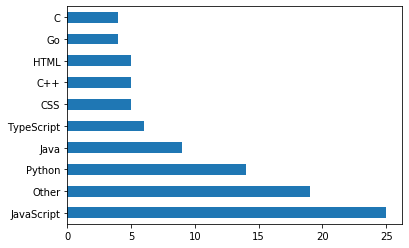

In [13]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()

In [14]:
df = df.drop(columns = ['repo'])

In [15]:
df.head(4)

,language,readme_contents
0,Java,# simple-java-maven-app\n\nThis repository is ...
1,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...
2,Python,# Full Stack Web Developer Nanodegree program ...
3,Other,![seclists.png](https://danielmiessler.com/ima...


In [16]:
y = df.language
X = df.readme_contents
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

In [17]:
train

,language,readme_contents
81,JavaScript,# Introduction\n\n[![npm version](https://img....
2,Python,# Full Stack Web Developer Nanodegree program ...
92,C,![Darknet Logo](http://pjreddie.com/media/file...
58,Java,<!-- the line below needs to be an empty line ...
39,TypeScript,"<p align=""center"">\n <a href=""https://ant.des..."
...,...,...
83,JavaScript,"# ECharts\n\n<a href=""https://echarts.apache.o..."
95,Other,# the-craft-of-selfteaching\n\n> One has no fu...
51,C,[![Build status](https://github.com/git/git/wo...
30,Java,> JavaGuide 的Star数量虽然比较多，但是它的价值和含金量一定是不能和 Dubb...


In [18]:
train1 = train.readme_contents.groupby(train.language).sum()

In [19]:
train1 = pd.DataFrame(train1).reset_index()

In [20]:
train1.head(4)

,language,readme_contents
0,C,![Darknet Logo](http://pjreddie.com/media/file...
1,C++,Bitcoin Core integration/staging tree\n=======...
2,CSS,# [Minimal Mistakes Jekyll theme](https://mmis...
3,Go,## 蓝灯(Lantern)最新版本下载 版本![](https://bitbucket.o...


In [21]:
train = prepare_r.prep_contents(train)

In [22]:
train = train.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])
train.head(4)

,language,readme_contents,cleaned
81,JavaScript,# Introduction\n\n[![npm version](https://img....,introduction npm version img shield npm admin ...
2,Python,# Full Stack Web Developer Nanodegree program ...,full stack web developer nanodegree program vi...
92,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...
58,Java,<!-- the line below needs to be an empty line ...,line need empty line kramdown isnt smart dearl...


In [23]:
train1 = prepare_r.prep_contents(train1)

In [24]:
train1 = train1.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])


In [25]:
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com           3305
org            903
python         829
javascript     592
doc            564
name           554
learning       519
library        504
data           500
machine        412
html           404
code           392
use            377
example        367
function       357
dtype: int64

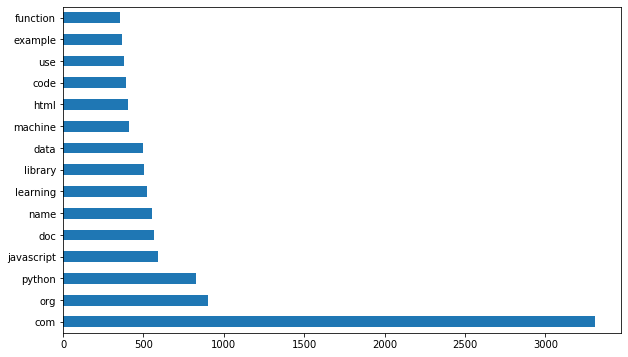

In [26]:
plt.figure(figsize = (10,6))
word_counts.plot.barh()

In [27]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [28]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['introduction', 'npm', 'version', ..., 'gcr', 'quay',
       'cloudnativeapp'], dtype=object)

In [29]:
# put the unique words into a data frame
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [32]:
idf_train.head(10)

,idf
word,
cloudnativeapp,76.0
association,76.0
hazard,76.0
additive,76.0
semiparametric,76.0
aizvorski,76.0
cran,76.0
ahaz,76.0
compressing,76.0


Text(0.5, 0, 'IDF value')

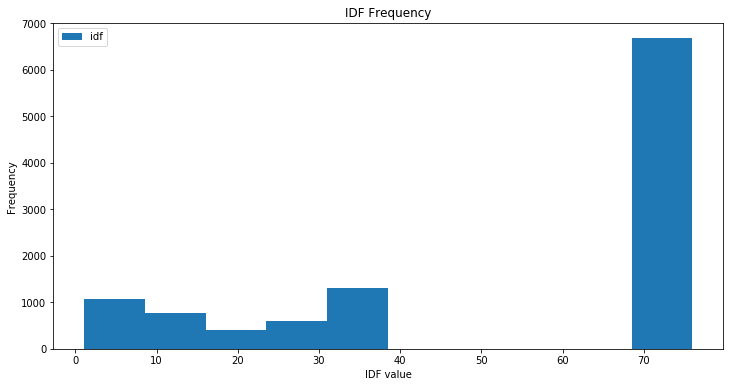

In [34]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')


In [35]:
# here we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

In [36]:
train

,language,readme_contents,cleaned,readme_words
81,JavaScript,# Introduction\n\n[![npm version](https://img....,introduction npm version img shield npm admin ...,382
2,Python,# Full Stack Web Developer Nanodegree program ...,full stack web developer nanodegree program vi...,815
92,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...,75
58,Java,<!-- the line below needs to be an empty line ...,line need empty line kramdown isnt smart dearl...,294
39,TypeScript,"<p align=""center"">\n <a href=""https://ant.des...",align center href ant design img width src ali...,1363
...,...,...,...,...
83,JavaScript,"# ECharts\n\n<a href=""https://echarts.apache.o...",echarts href echarts apache org img style vert...,462
95,Other,# the-craft-of-selfteaching\n\n> One has no fu...,craft selfteaching one ha future one teach the...,387
51,C,[![Build status](https://github.com/git/git/wo...,build status com git git workflow badge svg co...,318
30,Java,> JavaGuide 的Star数量虽然比较多，但是它的价值和含金量一定是不能和 Dubb...,javaguide star dubbonacos java javaguide doc j...,1174


(0, 10000)

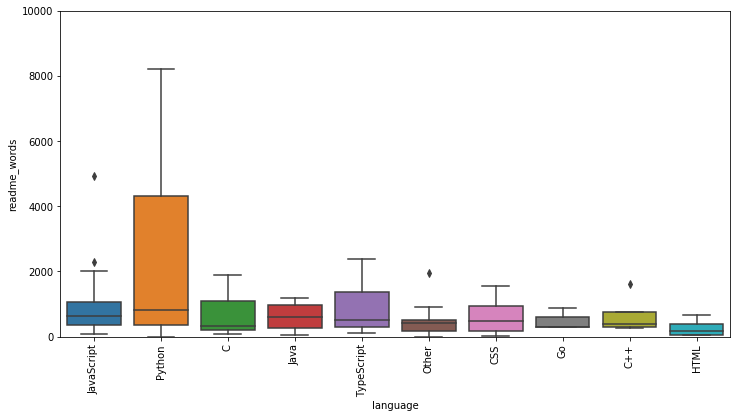

In [37]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,10000)

(0, 2000)

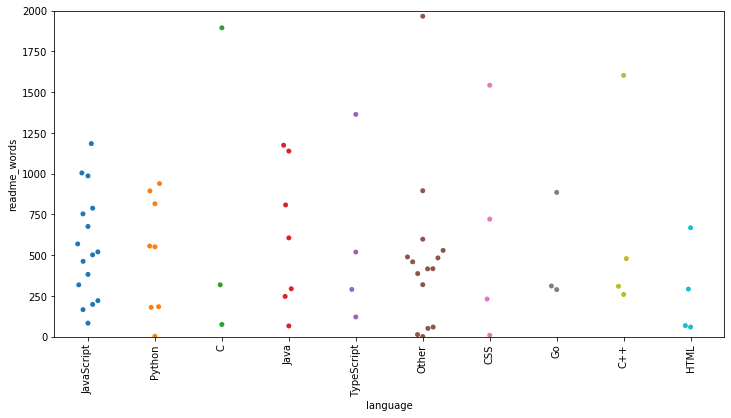

In [38]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,2000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread

In [39]:
# Next lets explore which words appear most often in a particular language
train.language.value_counts()

JavaScript    20
Other         15
Python        11
Java           7
TypeScript     5
HTML           4
C++            4
CSS            4
Go             3
C              3
Name: language, dtype: int64

In [40]:
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
TypeScript_words = pd.Series(' '.join(train[train.language == 'TypeScript'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
CSS_words = pd.Series(' '.join(train[train.language == 'CSS'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()
C_words = pd.Series(' '.join(train[train.language == 'C'].cleaned).split()).value_counts()
Go_words = pd.Series(' '.join(train[train.language == 'Go'].cleaned).split()).value_counts()

In [41]:
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, TypeScript_words, Cplus_words,\
                         CSS_words,HTML_words, C_words, Go_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'TypeScript', 'C++',\
                         'CSS','HTML', 'C', 'Go_'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.head()

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
aac,2,0,0,2,0,0,0,0,0,0,0
aafb,1,0,0,1,0,0,0,0,0,0,0
aan,1,1,0,0,0,0,0,0,0,0,0
aanzee,2,2,0,0,0,0,0,0,0,0,0
aarch,1,0,1,0,0,0,0,0,0,0,0


In [42]:
word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,3305,861,270,1457,185,188,135,98,65,12,34
org,903,306,43,392,50,47,28,17,5,4,11
python,829,1,12,797,1,0,18,0,0,0,0
javascript,592,479,2,46,0,4,5,0,56,0,0
doc,564,185,25,88,210,20,13,15,0,0,8
name,554,377,6,146,7,4,1,5,0,7,1
learning,519,8,6,484,7,8,4,0,2,0,0
library,504,33,11,449,0,6,0,0,0,5,0
data,500,111,24,308,22,7,2,1,0,25,0
machine,412,7,5,399,0,0,0,1,0,0,0


In [43]:
word_counts.sort_values(by='Python', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,3305,861,270,1457,185,188,135,98,65,12,34
python,829,1,12,797,1,0,18,0,0,0,0
learning,519,8,6,484,7,8,4,0,2,0,0
library,504,33,11,449,0,6,0,0,0,5,0
machine,412,7,5,399,0,0,0,1,0,0,0
org,903,306,43,392,50,47,28,17,5,4,11
data,500,111,24,308,22,7,2,1,0,25,0
youtube,294,5,0,287,0,2,0,0,0,0,0
video,268,2,4,243,1,13,0,0,5,0,0
html,404,160,15,197,21,2,3,4,2,0,0


Text(0.5, 1.0, 'Word cloud for all words')

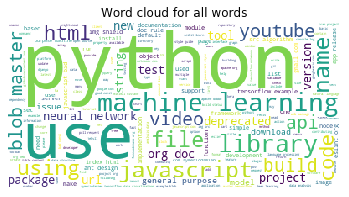

In [70]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

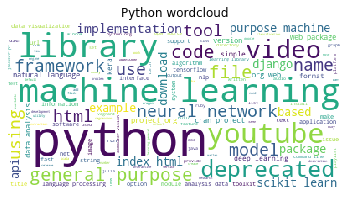

In [69]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

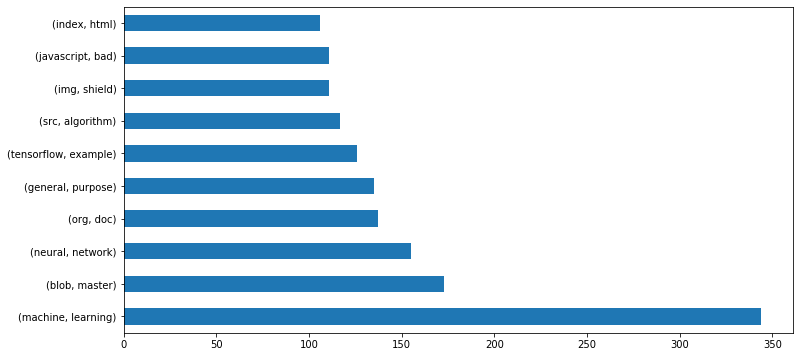

In [56]:
#lets look at bigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [65]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

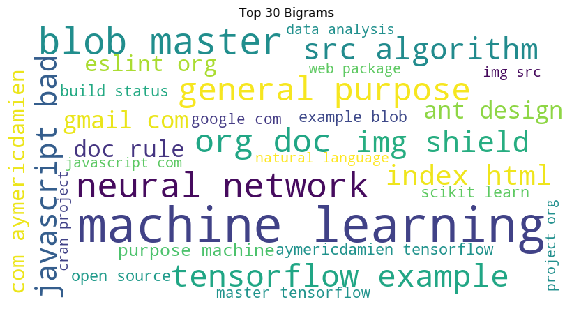

In [68]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

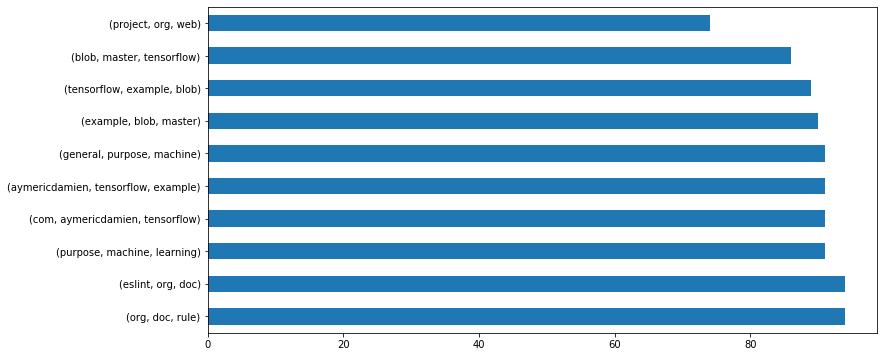

In [661]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [660]:
pd.Series(bigrams)

Series([], dtype: float64)